# Dependencias
Importamos dependencias necesarias

In [1]:
import torch
from torch.nn import functional as F
from diffusers import PNDMScheduler, UNet2DModel
from diffusers import schedulers
# from PIL import Image

import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms

# Funciones auxiliares necesarias

In [2]:
def show_images(images_tensor:torch.tensor, cmap = "grey"):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap);
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap);

In [3]:
def show_images_list(images_list:list[torch.Tensor], cmap = "grey") -> None:

    images_tensor = torch.concat(images_list,dim=0)

    # return images_tensor
    # show_images(images_tensor.unsqueeze(1))
    show_images(images_tensor.unsqueeze(1),cmap)


# Dataset
Usaremos fashionMNIST como dataset de datos En Distribución (IOD) y sus versiones Volteadas como dataset Fuera de Distribución (OOD)

De momento, solamente vamos a entrenar a la red, por lo que no necesitaremos las distribuciones OOD

In [4]:
preprocess = transforms.Compose([
    transforms.ToTensor(),              #To Torch Tensor
    transforms.Pad(2),                  # Add a padding of 2 pixels
    transforms.Normalize([0.5], [0.5])  # Normalize to (-1,1)
])

def dataset_preprocess(examples):
    images = [preprocess(example) for example in examples["image"]]
    return {"images": images}

In [5]:
dataset = load_dataset("fashion_mnist")

train_dataset,test_dataset = torch.utils.data.random_split(dataset["train"].with_transform(dataset_preprocess),(0.8,0.2))

val_dataset = torch.utils.data.random_split(dataset["test"].with_transform(dataset_preprocess),(1,))[0]


In [6]:
train_dataloder = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=256
)
test_dataloder = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=True,
    batch_size=256
)
val_dataloder = torch.utils.data.DataLoader(
    val_dataset,
    shuffle=True,
    batch_size=256
)

# Modelo
Creamos e instanciamos el modelo a utilizar.

In [7]:
# El modelo será una Unet 2D

model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    out_channels=1,
    sample_size=32,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),

).cuda()

In [8]:
scheduler = PNDMScheduler(
    num_train_timesteps=1000, beta_start=0.0015, beta_end=0.0195
)

In [9]:
# Parámetros de Entrenamiento

n_epochs = 50
lr = 3e-4

optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

loss_fn = F.mse_loss

# Bucles de Entrenamiento

In [10]:
from torch import nn
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, scheduler: schedulers, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   # Preparo el modelo para el entrenamiento

    train_losses = 0
    losses_list = []

    for nlote,x in enumerate(loader):
        x = x["images"].cuda()

        ## Noise
        # Make noise
        noise = torch.randn_like(x).cuda()

        # Create random timesteps to the training
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (x.shape[0],)
        ).long().cuda()

        # Add Noise to images
        noisy_x = scheduler.add_noise(x,noise,timesteps)

        ## Forward Pass
        noise_pred = model(noisy_x, timesteps, return_dict = False)[0]
        
        
        ## Back-propagation
        # Calc of loss
        loss = loss_fn(noise_pred, noise)    # Calculo de loss
        
        # Save Loss
        losses_list.append(loss.item())

        # Steps of training
        loss.backward()             # Calculo de gradiente
        optimizer.step()            # Actualización de parámetros
        optimizer.zero_grad()       # Limpieza del optimizador

        # Guardamos algunas características para plotear al final
        train_losses += loss.item()

        # Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print()

    train_losses /= nlotes
    print()
    print("Loss Promedio")
    print(f"Entrenamiento: {train_losses:>8f}")

    return losses_list

In [11]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, scheduler: schedulers, loss_fn:callable):
    
    # val_size = len(loader.dataset)
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Cancelo el calculo del gradiente
        for x in loader:
            
            x = x["images"].cuda()
            
            ## Noise
            noise = torch.randn_like(x)

            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (x.shape[0],)
            ).long().cuda()

            noisy_x = scheduler.add_noise(x, noise, timesteps)

            noise_pred = model(noisy_x, timesteps, return_dict=False)[0]       # Inferencia
            
            loss = loss_fn(noise_pred, noise)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"Validación: {val_losses:>8f}")

    return losses_list


# Entrenamiento de la Red

In [12]:
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    print(f"Iteración: {(epoch + 1)} / {n_epochs} -----------------------------")
    
    #Train
    train_loss  += train_loop(train_dataloder,model,scheduler,optimizer,loss_fn)
    
    #Validation
    val_output = val_loop(test_dataloder,model,scheduler,loss_fn)
    val_loss += val_output

print("Finalizado entrenamiento del modelo!")

Iteración: 1 / 50 -----------------------------
Nº de lote:	 0
Loss:			 1.2919635772705078

Nº de lote:	 10
Loss:			 0.18904942274093628

Nº de lote:	 20
Loss:			 0.12816199660301208

Nº de lote:	 30
Loss:			 0.11549197137355804

Nº de lote:	 40
Loss:			 0.09025298058986664

Nº de lote:	 50
Loss:			 0.06806109845638275

Nº de lote:	 60
Loss:			 0.07423672080039978

Nº de lote:	 70
Loss:			 0.06507061421871185

Nº de lote:	 80
Loss:			 0.06145403906702995

Nº de lote:	 90
Loss:			 0.04426891729235649

Nº de lote:	 100
Loss:			 0.054577361792325974

Nº de lote:	 110
Loss:			 0.05157124623656273

Nº de lote:	 120
Loss:			 0.05101798474788666

Nº de lote:	 130
Loss:			 0.044549450278282166

Nº de lote:	 140
Loss:			 0.05517115071415901

Nº de lote:	 150
Loss:			 0.03931017220020294

Nº de lote:	 160
Loss:			 0.03864440321922302

Nº de lote:	 170
Loss:			 0.040974102914333344

Nº de lote:	 180
Loss:			 0.035170093178749084


Loss Promedio
Entrenamiento: 0.090966
Validación: 0.040987
Iteraci

In [13]:
torch.save(model.state_dict(),"Base_model_OOD_detection.pth")

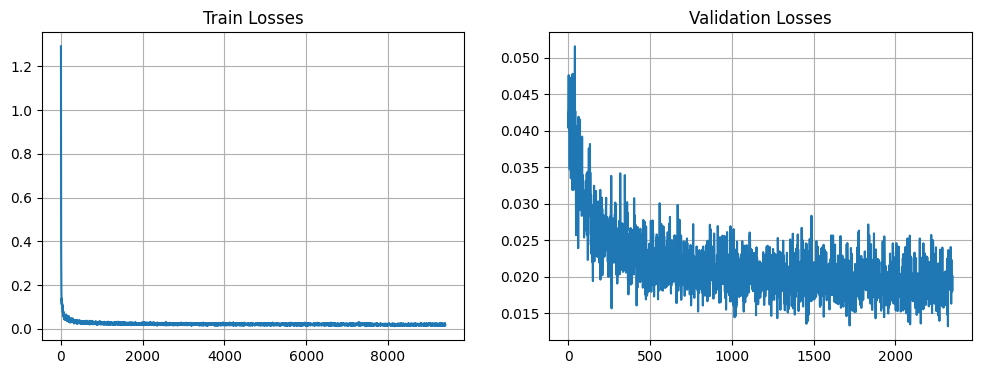

In [14]:
plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Train Losses")
plt.plot(range(len(train_loss)),train_loss);
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation Losses")
plt.plot(range(len(val_loss)),val_loss);
plt.grid()

# Pruebas

In [ ]:
img_batch = next(iter(train_dataloder))["images"].cuda()

prediction = model(img_batch,5)

In [ ]:
prediction[0].shape

In [ ]:
len(train_dataset)

In [ ]:
len(train_dataloder)